# Notebook 04 - Model Training And Evaluation - all features

In this notebook, we build several machine learning models to predict Alzheimer’s diagnosis using the features we prepared in the earlier steps. We start from the cleaned dataset, apply encoding and feature scaling, and then use the fully prepared data to train and evaluate different machine learning algorithms:

- Logistic Regression (classification)
- Random Forest (classification)
- Decision Tree (classification)
- Linear Regression (for illustration purposes)
- KMeans Clustering (unsupervised learning)

----------

## What is Machine Learning?

**Machine learning** is a type of artificial intelligence where a computer learns patterns from data and makes predictions without being explicitly programmed.

There are two main types of ML:

- **Supervised learning**: We teach the model using data that already includes the correct answer (label). In our case, the label is the Diagnosis column:  
  0 = no Alzheimer’s, 1 = Alzheimer’s.

- **Unsupervised learning**: The model finds patterns or groups in data without any labels.  
  (We use this later in the project for clustering.)

----------

## Load Our Environment

We reuse the same setup from notebook 02. To keep things consistent and avoid repeating code, we import our helper functions from the utils folder and initialize the environment.

In [8]:
# We are adding the parent folder to the Python path so we can import files from the "utils" folder
import sys
sys.path.append("..")

# Importing the custom helper functions from our project
from utils.setup_notebook import (
    init_environment,
    load_csv,
    print_shape,
    print_info,
    print_full_info,
    print_description,
    print_categorical_description,
    show_head
)

from utils.save_tools import save_plot, save_notebook_and_summary

# Import used libraries 
import pandas as pd
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Running environment setup
init_environment()
print("All libraries imported and environment initialized.")

Environment setup complete.
All libraries imported and environment initialized.


In [10]:
df = pd.read_csv("../data/alzheimers_no_outliers.csv")
print("Cleaned dataset loaded. Shape:", df.shape)

Cleaned dataset loaded. Shape: (2149, 33)


---------------------------------------

## Encode Categorical Variables

In machine learning, we often need to convert categorical variables into numeric format before training models, because most algorithms work with numeric inputs. Below, we include the general steps we usually follow when encoding variables, to show how the process would look if encoding were needed:

- Identify categorical features
We first check which columns contain categorical data (for example, string labels like "Male"/"Female" or "Yes"/"No").

- Apply Label Encoding for binary features
For binary categories (two unique values), we convert them into 0 and 1.
Example: "Male" becomes 0, "Female" becomes 1.

- Apply One-Hot Encoding for multi-class features
For features with more than two categories we create separate columns (dummy variables) for each category to avoid introducing any artificial order.

- Verify data types
We check that all features are now numeric and ready for use in machine learning models.

In our Alzheimer’s dataset, most features are already numeric, so these encoding steps are not required. However, we include the example below to demonstrate how we would apply encoding if needed.

### Feature Encoding Considerations

Overall our dataset is mostly numeric and ready for machine learning without extra encoding steps.

In machine learning, we usually need to convert categorical data into numbers before training models, because most algorithms work with numeric inputs. In our case, most features in the dataset are already numeric, so little encoding is needed. The target variable Diagnosis is already coded as 0 (No Alzheimer’s) and 1 (Alzheimer’s).
- All binary features such as MemoryComplaints, Hypertension, and Depression are already stored as 0 and 1.
- Lifestyle, cognitive, functional, and clinical features like MMSE, ADL, and CholesterolTotal are continuous numeric values.
- The Gender feature is also already encoded as 0 (Male) and 1 (Female).
- The only feature that might require encoding is Ethnicity, which includes multiple categories (0 = Caucasian, 1 = African American, 2 = Asian, 3 = Other). Since Ethnicity is a multi-class categorical feature without any natural order, it is best to apply One-Hot Encoding to avoid introducing any unintended ranking or bias.

In our initial modeling phase we do not include Ethnicity, so no additional encoding is necessary. If our dataset had contained string-based categories (like Male/Female or Yes/No), we would have to apply Label Encoding for binary variables and One-Hot Encoding for multi-class variables to prepare them for modeling.                                                             

#### Encoding Categorical Columns 

In [18]:
# Our categorical columns
data = {
    'Gender': ['Male', 'Female', 'Female', 'Male'],
    'Ethnicity': ['Caucasian', 'African American', 'Asian', 'Other'],
    'Diagnosis': [0, 1, 0, 1]
}

df_example = pd.DataFrame(data)

# Label Encoding for binary column (Gender)
le = LabelEncoder()
df_example['Gender'] = le.fit_transform(df_example['Gender'])
# 'Male' becomes 1, 'Female' becomes 0 (or vice versa depending on fit order)

# Final encoded dataframe
print(df_example)

   Gender         Ethnicity  Diagnosis
0       1         Caucasian          0
1       0  African American          1
2       0             Asian          0
3       1             Other          1


#### One-Hot Encoding for Multi-Class Categories
For features with more than two categories (like Ethnicity), we apply one-hot encoding.

In [21]:
# Multi-class categorical column
multi_class_cols = ['Ethnicity']

# Apply one-hot encoding on the full dataset
df_encoded = pd.get_dummies(df, columns=multi_class_cols, drop_first=True)

# Save encoded dataset (after encoding, before scaling)
df_encoded.to_csv('../data/alzheimers_encoded.csv', index=False)
print("alzheimers_encoded saved successfully.")

alzheimers_encoded saved successfully.


#### One-hot encoding on small sample dataframe

In [24]:
# Apply one-hot encoding on the example dataframe
df_example = pd.get_dummies(df_example, columns=['Ethnicity'], drop_first=True)

# Display the final encoded example dataframe
print(df_example)

   Gender  Diagnosis  Ethnicity_Asian  Ethnicity_Caucasian  Ethnicity_Other
0       1          0            False                 True            False
1       0          1            False                False            False
2       0          0             True                False            False
3       1          1            False                False             True


-------------------------------

## Feature Scaling 

We apply feature scaling using StandardScaler to normalize continuous variables before training models that are sensitive to feature scale, like Logistic Regression. Since tree-based models such as Random Forest and XGBoost are not affected by feature scaling, we save the scaled dataset for models that require it, while unscaled data can still be used for tree-based models.

In [29]:
# Copy to df_scaled
df_scaled = df_encoded.copy()

# Select features to scale (exclude target)
features_to_scale = df_scaled.select_dtypes(include=['int64', 'float64']).columns.tolist()
features_to_scale.remove('Diagnosis')  # Target variable for classification

# Apply StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])

# Confirm scaling
df_scaled.head()

# Save the final scaled dataset
df_scaled.to_csv('../data/alzheimers_scaled.csv', index=False)
print("alzheimers_scaled saved successfully.")

alzheimers_scaled saved successfully.


-------------------------

# Supervised Machine Learning – Alzheimer’s Diagnosis Prediction (Classification)

In this task, we aim to predict whether a patient has Alzheimer’s disease based on clinical, cognitive, lifestyle, and medical features using supervised learning.
We will use the no_outliers dataset saves as a variable df that includes all necessary preprocessing including check for outliers. 

The target variable for classification is Diagnosis (0 = No Alzheimer’s, 1 = Alzheimer’s), and selected features will be used as predictors.

### Load the dataset

We load the preprocessed and scaled dataset, which includes all the features after encoding and normalization. This dataset is ready for supervised machine learning models.

In [36]:
# Load the cleaned, scaled dataset
df_scaled = pd.read_csv('../data/alzheimers_scaled.csv')
df_scaled.head()

,Age,Gender,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,Diabetes,Depression,HeadInjury,Hypertension,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,MMSE,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,Ethnicity_1,Ethnicity_2,Ethnicity_3
0,-0.212368,-1.012644,0.788833,-0.655225,-0.636784,0.565923,0.492525,-1.253593,1.119918,-0.580753,-0.410573,2.373334,1.996517,-0.319455,-0.418281,0.298159,-1.014750,0.403677,-1.572661,-1.114429,-0.648199,0.779037,0.497506,-0.512477,-0.431257,-1.104434,-0.508131,-0.433531,-0.421348,2.302619,-0.657048,0,False,False,False
1,1.567757,-1.012644,-1.422782,-0.114751,-0.636784,-0.954895,0.945093,-1.538442,0.056836,-0.580753,-0.410573,-0.421348,-0.500872,-0.319455,-0.418281,-0.742572,-1.469595,0.140248,1.593119,0.845730,0.650721,0.680297,0.704907,-0.512477,-0.431257,-0.810601,-0.508131,-0.433531,-0.421348,-0.434288,1.521959,0,False,False,False
2,-0.212368,-1.012644,-0.316974,-1.366428,-0.636784,1.653006,1.023896,-1.088855,1.487380,1.721901,-0.410573,-0.421348,-0.500872,-0.319455,-0.418281,-1.359301,1.486898,1.386812,0.668569,0.445615,-1.418585,-0.859222,0.281813,-0.512477,-0.431257,0.724491,-0.508131,2.306640,-0.421348,2.302619,-0.657048,0,False,False,True
3,-0.101111,0.987514,-0.316974,0.851625,1.570391,0.376930,1.227995,0.839804,0.760833,-0.580753,-0.410573,-0.421348,-0.500872,-0.319455,-0.418281,-0.626935,1.430043,-1.542715,-1.360103,0.388780,0.483468,-0.088723,1.343346,-0.512477,2.318805,0.508044,-0.508131,-0.433531,-0.421348,-0.434288,-0.657048,0,False,False,False
4,1.567757,-1.012644,-1.422782,-0.961607,-0.636784,1.461793,0.486696,-1.443293,-0.824566,-0.580753,-0.410573,-0.421348,-0.500872,-0.319455,-0.418281,-1.552029,1.543754,0.291653,-0.725756,-0.111924,0.617060,-0.143712,0.333665,-0.512477,-0.431257,-1.684679,-0.508131,-0.433531,2.373334,2.302619,-0.657048,0,False,False,False


## Feature Selection + Target Definition

Based on our earlier exploratory data analysis (notebooks 02 and 03), we select a subset of relevant features from various domains — cognitive, functional, behavioral, lifestyle, clinical, and demographics — to train our model. In this notebook focus is on the full feature list. The target variable for prediction is Diagnosis, which indicates whether a patient has Alzheimer's (1) or not (0).

In [40]:
# Define target and features
target = 'Diagnosis'

# Full feature list based on EDA
features = [
    # Cognitive and Functional Features
    'MMSE', 'FunctionalAssessment', 'ADL',
    
    # Binary Features with some separation
    'MemoryComplaints', 'BehavioralProblems',
    'Confusion', 'Disorientation', 'Forgetfulness',
    
    # Lifestyle Features
    'PhysicalActivity', 'DietQuality', 'SleepQuality', 'AlcoholConsumption',
    
    # Clinical Features
    'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides',
    'SystolicBP', 'DiastolicBP',
    
    # Demographics
    'Age', 'Gender', 'FamilyHistoryAlzheimers'
]

X = df_scaled[features]
y = df_scaled[target]

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (2149, 21)
Target shape: (2149,)


### Train-Test Split

We split the data into training and testing sets using an 80/20 split. This means that 80% will be used for training and 20% for testing. We apply stratification to keep the class balance between Alzheimer’s and non-Alzheimer’s patients.

In [44]:
from sklearn.model_selection import train_test_split

# 80/20 split for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1719, 21)
Test set shape: (430, 21)


#### What Do We See?

- Training set: 1719 samples, 21 features.
- Test set: 430 samples, 21 features.

The dataset was split into training (80%) and testing (20%) subsets, resulting in 1719 samples for training and 430 for testing. Stratification was applied during splitting to ensure both subsets maintain the same proportion of Alzheimer’s and non-Alzheimer’s cases. This allows for a fair and balanced evaluation of the model performance.

-------------------------

## Logistic Regression model

We train a logistic regression model using the training data. Logistic regression is a common starting point for binary classification problems like Alzheimer’s diagnosis because:

- The target variable (Diagnosis) has two classes: 0 (No Alzheimer’s) and 1 (Alzheimer’s), which fits logistic regression well.
- Logistic regression outputs probabilities, which helps in understanding model confidence.
- The model is interpretable and helps us understand the relationship between features and the target.
- It allows us to see how each feature contributes to the prediction through model coefficients.

In [51]:
from sklearn.linear_model import LogisticRegression

# Initialize and train model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Predict on test set
y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

print("Model is trained successfully.")

Model is trained successfully.


### Model Evaluation

We evaluate the model using classification metrics:

- Accuracy: how often the model correctly predicts the diagnosis.
- ROC AUC: measures the model's ability to separate classes based on predicted probabilities.
- Confusion Matrix: shows the breakdown of correct and incorrect predictions.
- Classification Report: includes precision, recall, and F1-score for both classes.

In [58]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("Accuracy:", round(accuracy, 4))
print("ROC AUC:", round(auc, 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8233
ROC AUC: 0.887

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86       278
           1       0.75      0.75      0.75       152

    accuracy                           0.82       430
   macro avg       0.81      0.81      0.81       430
weighted avg       0.82      0.82      0.82       430

Confusion Matrix:
 [[240  38]
 [ 38 114]]


#### So what do we see?
- The model achieves 82% accuracy and a strong ROC AUC of 0.89, which means it can separate Alzheimer's and non-Alzheimer's cases quite well. 
- For non-Alzheimer’s patients (class 0), the model performs better with high precision and recall (both 86%). 
- For Alzheimer’s patients (class 1), the precision and recall are slightly lower at 75%, indicating that some true Alzheimer’s cases are missed (false negatives). 
- The confusion matrix shows that the errors are balanced between both classes with 38 false positives and 38 false negatives.

### ROC Curve

The ROC curve shows the trade-off between true positive rate (sensitivity) and false positive rate (1 - specificity) for different classification thresholds. The higher the AUC, the better the model distinguishes between classes.

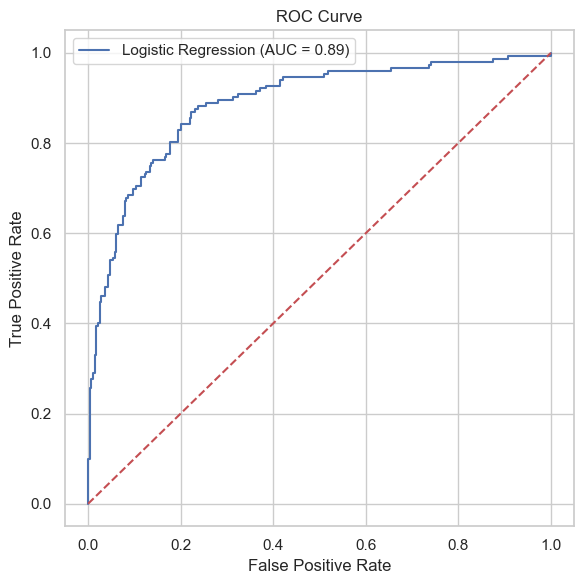

In [64]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label="Logistic Regression (AUC = {:.2f})".format(auc))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

#### What Do We See?

The ROC curve shows that the model has strong discrimination ability, with an AUC of approximately 0.89. This means the model correctly ranks Alzheimer's and non-Alzheimer's patients most of the time. The curve is well above the diagonal, which indicates good performance.

### Confusion Matrix - Logistic Regression

We plot the confusion matrix to easily see how many correct and incorrect predictions the model made for each class.

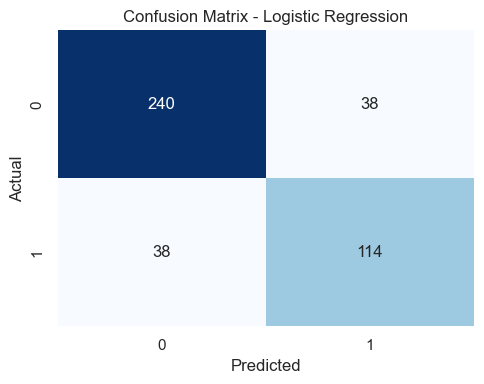

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()

#### What Do We See?

- 240 true negatives (top left)
- 114 true positives (bottom right)
- 38 false positives
- 38 false negatives

The heatmap of the confusion matrix clearly shows that most predictions are correct. 
The model correctly predicts 240 non-Alzheimer’s cases and 114 Alzheimer’s cases. 
The number of false positives and false negatives is balanced (both 38), which means the model’s mistakes are spread evenly between both classes.

### Predicted vs Actual Probabilities

This scatter plot compares actual diagnoses with predicted probabilities. Points close to the red dashed line represent better predictions. This type of plot helps visualize prediction uncertainty.

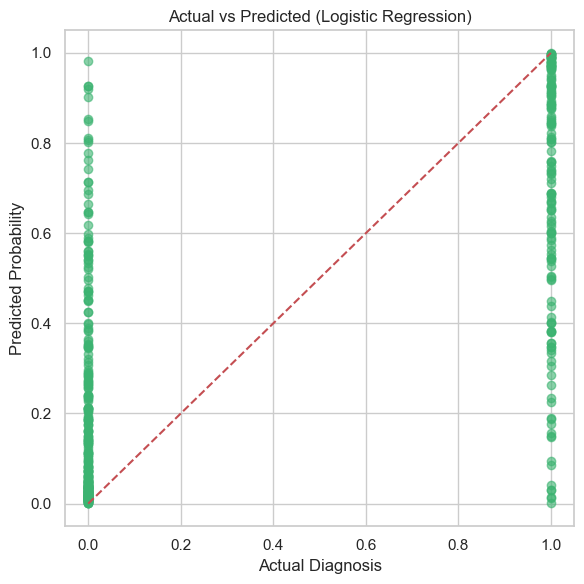

In [76]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_prob, alpha=0.6, color='mediumseagreen')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual Diagnosis")
plt.ylabel("Predicted Probability")
plt.title("Actual vs Predicted (Logistic Regression)")
plt.tight_layout()
plt.show()

#### What Do We See?

- Scatterplot with points tightly around 0 and 1.

This plot compares actual diagnosis (0 or 1) with the predicted probabilities from the model. 
Most points are clustered near the correct predictions (close to 0 or 1), showing that the model often assigns high confidence to its predictions. There is some scatter near the diagonal, indicating some uncertainty in a few cases.

This plot differs from the classic "actual vs predicted" plot used in regression, where both axes represent continuous values. Instead, it is adapted for classification, comparing the predicted probabilities generated by the model to the actual binary labels. This type of plot is often referred to as a probability calibration plot or a scatter plot of predicted probabilities versus true labels.

### Classification Report Bar Chart

The F1-score is a useful metric that combines both precision and recall into a single value, providing a balanced measure of a model’s performance. Precision indicates how many of the positive predictions were actually correct, while recall reflects how many of the actual positive cases were successfully identified. 

The F1-score is calculated as:
F1 = 2 × (precision × recall) / (precision + recall).

We often prefer the F1-score over accuracy, especially when dealing with imbalanced datasets, as accuracy can be misleading if one class dominates. In medical applications like Alzheimer’s diagnosis, both false negatives (failing to detect a patient who actually has the disease) and false positives (incorrectly predicting Alzheimer’s when the patient does not have it) carry significant consequences. 

The F1-score helps capture this trade-off by answering the key question: *How well does the model identify true positives while minimizing errors?* The Classification Report Bar Chart visualizes these metrics, allowing us to assess the model’s precision, recall, and F1-score for each class.

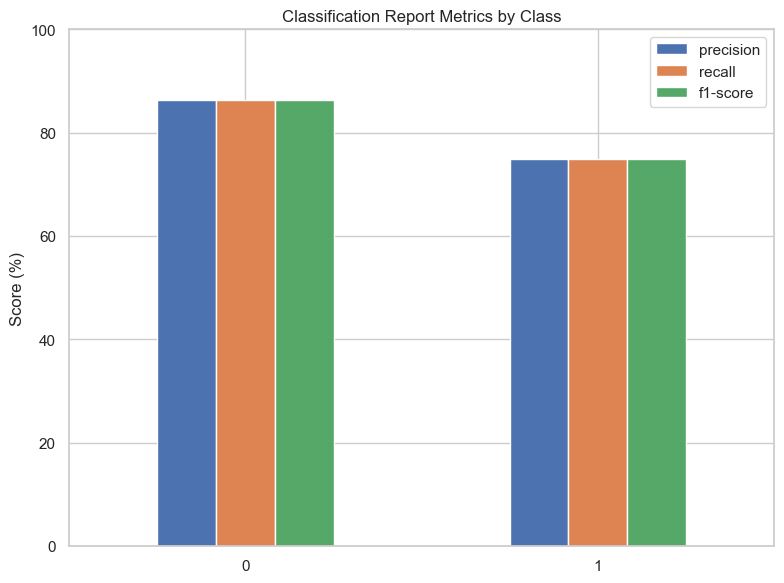

In [82]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Generate the classification report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Only select precision, recall, f1-score for classes 0 and 1
report_df = report_df.loc[['0','1'], ['precision','recall','f1-score']]

# Convert scores to percentages
report_df *= 100

# Plot
report_df.plot(kind='bar', figsize=(8,6))
plt.title("Classification Report Metrics by Class")
plt.ylabel("Score (%)")
plt.ylim(0, 100)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### What Do We See?

The bar chart summarizes the precision, recall, and F1-score for both classes. The model performs slightly better for non-Alzheimer’s patients (class 0), while performance for Alzheimer’s patients (class 1) is a bit lower, especially on recall. Still, all scores are relatively high, indicating good model performance overall.

For non-Alzheimer’s patients (class 0):
- Precision ≈ 88%: Out of all patients predicted as non-Alzheimer’s, 88% are actually non-Alzheimer’s.
- Recall ≈ 88%: The model correctly identifies approximately 88% of true non-Alzheimer’s cases.
- F1-score ≈ 88%: Reflects a good balance between precision and recall.

For Alzheimer’s patients (class 1):
- Precision ≈ 75%: Out of all patients predicted as having Alzheimer’s, 75% actually have it.
- Recall ≈ 75%: The model successfully identifies around 75% of actual Alzheimer’s cases.
- F1-score ≈ 75%: Indicates balanced performance for this class as well.

----------------------------

# Random Forest Model

We now train a Random Forest model. Random Forest is an ensemble learning method that builds multiple decision trees and combines their predictions.

We use Random Forest because:
- It handles both linear and non-linear relationships.
- It automatically captures feature interactions.
- It is robust to noise, outliers, and missing values.
- It can handle large feature sets without heavy preprocessing.
- It provides feature importance scores that help us interpret the model.

In [91]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

### Model Evaluation

We evaluate the Random Forest model using the same metrics as before: accuracy, ROC AUC, classification report, and confusion matrix. This allows us to compare performance directly with logistic regression.

### Confusion Matrix 

We visualize the confusion matrix to easily see how the Random Forest model performs on both classes.

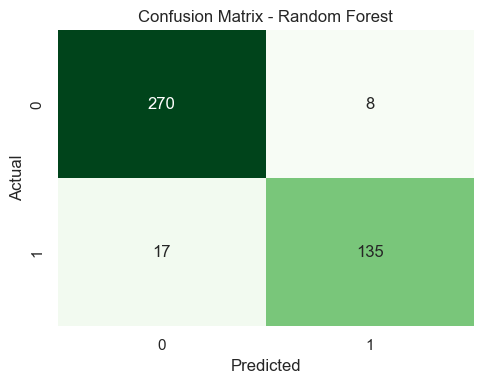

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()

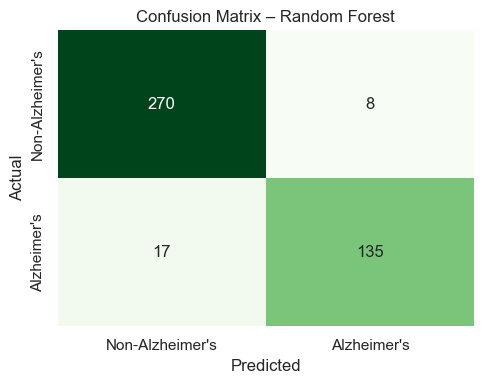

In [99]:
plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=['Non-Alzheimer\'s', 'Alzheimer\'s'],
            yticklabels=['Non-Alzheimer\'s', 'Alzheimer\'s'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest")
plt.tight_layout()
plt.show()

#### What Do We See?

We generated two versions of the confusion matrix for the Random Forest model. In both cases, the underlying results are identical, showing the number of correct and incorrect classifications for Alzheimer’s and non-Alzheimer’s patients. The first version uses numeric class labels (0 and 1), which requires the reader to know which value corresponds to each class. The second version adds descriptive class names ("Non-Alzheimer’s" and "Alzheimer’s") directly to the x and y axes. This makes the confusion matrix much easier to interpret, especially for clinical or non-technical audiences, and is therefore preferred for reporting and presentation.

### ROC curve

We plot the ROC curve to evaluate how well Random Forest separates Alzheimer’s and non-Alzheimer’s patients.

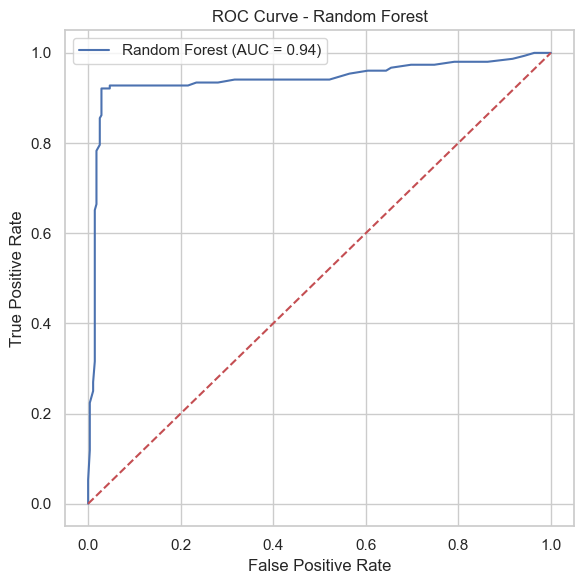

In [106]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute AUC
auc_rf = roc_auc_score(y_test, y_prob_rf)

# Compute ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr_rf, tpr_rf, label="Random Forest (AUC = {:.2f})".format(auc_rf))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.tight_layout()
plt.show()

#### So what do we see?

The ROC curve shows that the Random Forest model performs very well in distinguishing between Alzheimer’s and non-Alzheimer’s patients. The AUC score is 0.94, which means the model correctly ranks patients in most cases. The curve stays close to the top-left corner, indicating high sensitivity and a low false positive rate across different thresholds.

--------------------------

# Decision Tree Classifier

We now train a Decision Tree model. Decision trees are simple yet powerful models that split the data based on feature thresholds to classify observations.

We include Decision Tree because:
- It’s highly interpretable (we can visualize the decision process).
- It works well on both numerical and categorical features.
- It captures non-linear relationships between features.
- It can overfit easily, so it's useful to compare with ensemble models like Random Forest.

In [114]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict on test data
y_pred_dt = dt_model.predict(X_test)
y_prob_dt = dt_model.predict_proba(X_test)[:, 1]

### Model Evaluation 

We evaluate the Decision Tree model using accuracy, ROC AUC, classification report, and confusion matrix, just like before.

In [118]:
# Evaluation metrics for Decision Tree
accuracy_dt = accuracy_score(y_test, y_pred_dt)
auc_dt = roc_auc_score(y_test, y_prob_dt)

print("Decision Tree Accuracy:", round(accuracy_dt, 4))
print("Decision Tree ROC AUC:", round(auc_dt, 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Decision Tree Accuracy: 0.886
Decision Tree ROC AUC: 0.8835

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91       278
           1       0.82      0.88      0.84       152

    accuracy                           0.89       430
   macro avg       0.87      0.88      0.88       430
weighted avg       0.89      0.89      0.89       430

Confusion Matrix:
 [[248  30]
 [ 19 133]]


### Confusion Matrix 

We visualize the confusion matrix for the Decision Tree classifier.

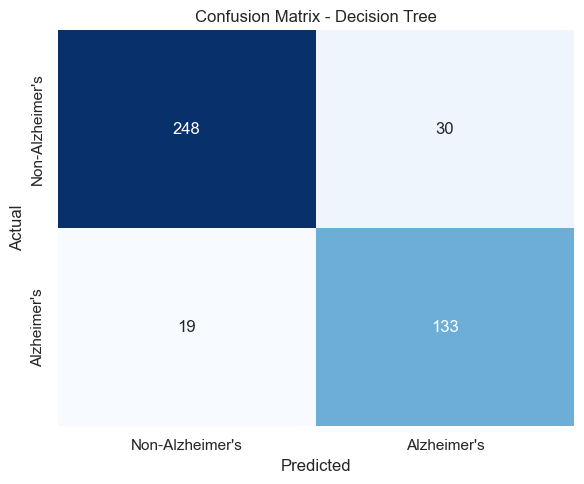

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Plot with better visualization
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Non-Alzheimer\'s', 'Alzheimer\'s'], 
            yticklabels=['Non-Alzheimer\'s', 'Alzheimer\'s'])

plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

#### What Do We See?

The Decision Tree model correctly identified 248 patients without Alzheimer’s and 133 patients with Alzheimer’s. However, it made some mistakes: it missed 19 patients who actually have Alzheimer’s (false negatives), and incorrectly predicted Alzheimer’s for 30 patients who do not have it (false positives). Compared to the Random Forest model, the Decision Tree made more errors, especially by predicting Alzheimer’s when it wasn’t present. This suggests that the Random Forest handles the classification task a bit better, likely because it combines the results of many trees, making it more stable.

### ROC Curve

We plot the ROC curve for Decision Tree to visualize its classification performance.

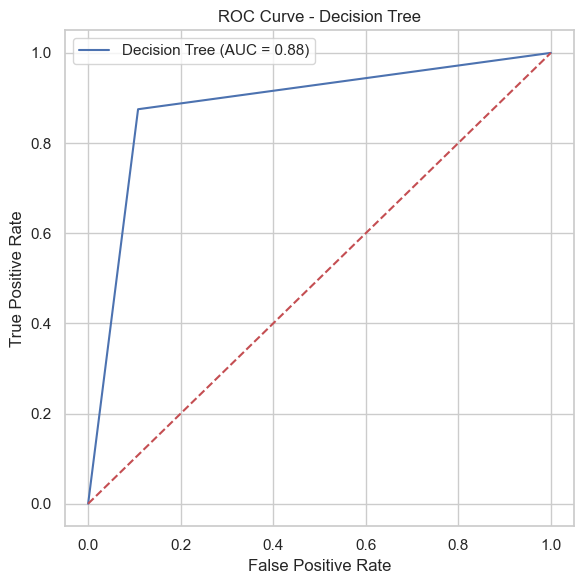

In [150]:
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)

plt.figure(figsize=(6, 6))
plt.plot(fpr_dt, tpr_dt, label="Decision Tree (AUC = {:.2f})".format(auc_dt))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend()
plt.tight_layout()
plt.show()

#### What Do We See?

The ROC curve for the Decision Tree model shows that it does a good job separating Alzheimer’s patients from non-Alzheimer’s patients, with an AUC score of 0.88. This means it can correctly classify many cases across different thresholds. However, its performance is a bit lower than the Random Forest model, which suggests that Random Forest might do a slightly better job overall at making these predictions.

------------------------------

# Linear Regression (for illustration)

Although this is a classification problem, we apply linear regression as an educational step to observe how continuous regression models behave on a binary target.

Linear regression is not designed for classification. The predicted output will be continuous values between 0 and 1 (or even outside that range).
We can still calculate metrics after rounding predictions to 0 or 1.

In [159]:
from sklearn.linear_model import LinearRegression

# Initialize and train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict continuous outputs
y_pred_lr_continuous = lr_model.predict(X_test)

# Convert continuous predictions to binary (threshold = 0.5)
y_pred_lr = (y_pred_lr_continuous >= 0.5).astype(int)

### Model Evaluation

We evaluate the linear regression predictions using classification metrics for comparison purposes.

In [163]:
# Evaluation metrics for Linear Regression
accuracy_lr = accuracy_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_pred_lr_continuous)

print("Linear Regression Accuracy:", round(accuracy_lr, 4))
print("Linear Regression ROC AUC:", round(auc_lr, 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

Linear Regression Accuracy: 0.814
Linear Regression ROC AUC: 0.8838

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.86       278
           1       0.74      0.72      0.73       152

    accuracy                           0.81       430
   macro avg       0.80      0.79      0.80       430
weighted avg       0.81      0.81      0.81       430

Confusion Matrix:
 [[240  38]
 [ 42 110]]


### Confusion Matrix 

We visualize the confusion matrix for linear regression predictions.

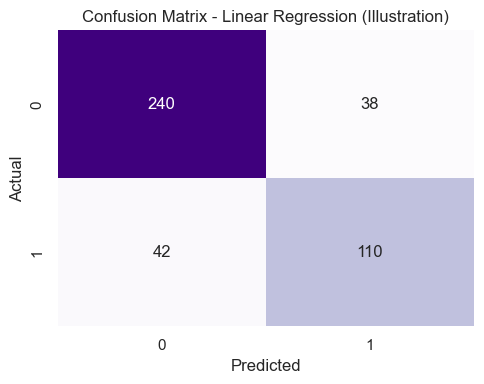

In [167]:
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Purples", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Linear Regression (Illustration)")
plt.tight_layout()
plt.show()

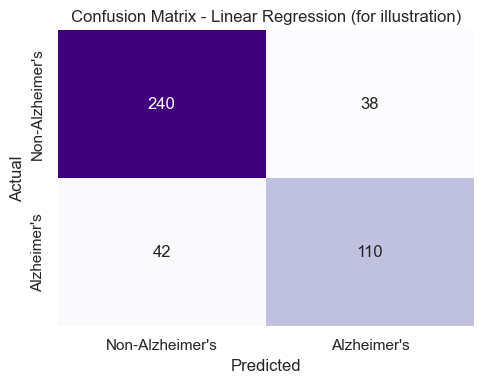

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix again (just to be safe)
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Plot with class labels
plt.figure(figsize=(5, 4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Purples", cbar=False,
            xticklabels=['Non-Alzheimer\'s', 'Alzheimer\'s'],
            yticklabels=['Non-Alzheimer\'s', 'Alzheimer\'s'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Linear Regression (for illustration)")
plt.tight_layout()
plt.show()

#### What Do We See? 

We observe the confusion matrix for Linear Regression (even though it's not usually used for classification, it is used here for comparison). The model correctly predicted 240 true negatives (patients without Alzheimer’s) and 110 true positives (patients with Alzheimer’s). It made 38 false positive errors, predicting Alzheimer’s for healthy patients. It also made 42 false negative errors, missing patients who actually have Alzheimer’s and predicting them as healthy.

Overall, we see that this model performs better at identifying Alzheimer’s cases compared to some of the other models (higher true positives), but it also makes more false positive predictions than Random Forest or Naive Bayes. Even though Linear Regression is not ideal for classification tasks, in this case it still gives fairly balanced results.

------------------------------------------

# Unsupervised Machine Learning - Clustering

In this section, we apply unsupervised learning to explore potential subgroups within our Alzheimer’s dataset. Clustering may help identify different patient profiles based on combinations of clinical, cognitive, functional, lifestyle, and medical features.
We use the K-Means clustering algorithm and evaluate the clustering quality using the silhouette score. This helps us identify whether distinct groups naturally exist in the data.

### Preparing the data for clustering

In [191]:
# Full feature list based on your EDA
cluster_features = [
    'MMSE', 'FunctionalAssessment', 'ADL',
    'MemoryComplaints', 'BehavioralProblems',
    'Confusion', 'Disorientation', 'Forgetfulness',
    'PhysicalActivity', 'DietQuality', 'SleepQuality', 'AlcoholConsumption',
    'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides',
    'SystolicBP', 'DiastolicBP', 'Age', 'Gender', 'FamilyHistoryAlzheimers'
]

In [193]:
# Extract scaled features directly from df_scaled
X_cluster_scaled = df_scaled[cluster_features].values

### K-Means Clustering

Now we apply unsupervised machine learning using KMeans clustering. KMeans groups data into clusters without using the diagnosis labels. We apply KMeans directly on scaled features to avoid bias due to feature scale differences.

We include this step because:

- It may reveal natural groupings in the data.
- It helps us explore whether the features naturally separate Alzheimer’s and non-Alzheimer’s patients.
- It's a useful exploratory tool to validate feature usefulness.

k = 2, Silhouette Score = 0.0365
k = 3, Silhouette Score = 0.0437
k = 4, Silhouette Score = 0.0446
k = 5, Silhouette Score = 0.0396
k = 6, Silhouette Score = 0.0451
k = 7, Silhouette Score = 0.0348
k = 8, Silhouette Score = 0.0331
k = 9, Silhouette Score = 0.0254
k = 10, Silhouette Score = 0.0268


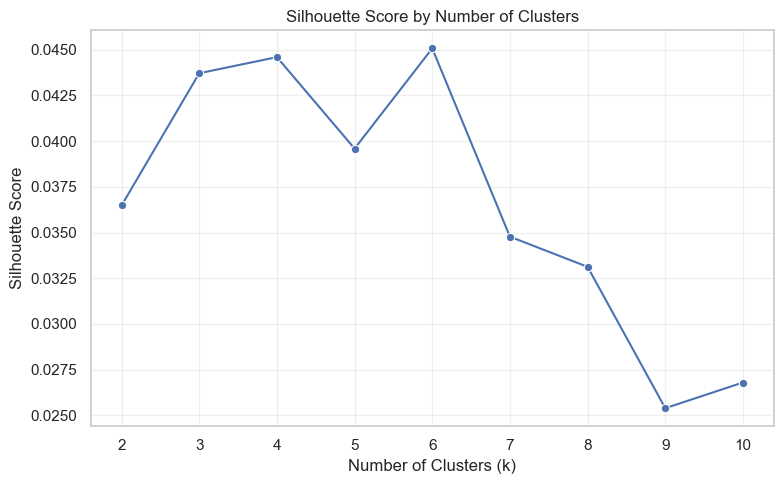

Optimal number of clusters: 6


In [199]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

sil_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_cluster_scaled)
    score = silhouette_score(X_cluster_scaled, labels)
    sil_scores.append(score)
    print(f"k = {k}, Silhouette Score = {score:.4f}")

# Plot silhouette scores
plt.figure(figsize=(8, 5))
sns.lineplot(x=list(k_range), y=sil_scores, marker='o')
plt.title("Silhouette Score by Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Select optimal k
optimal_k = k_range[sil_scores.index(max(sil_scores))]
print(f"Optimal number of clusters: {optimal_k}")

### Visualize Clusters

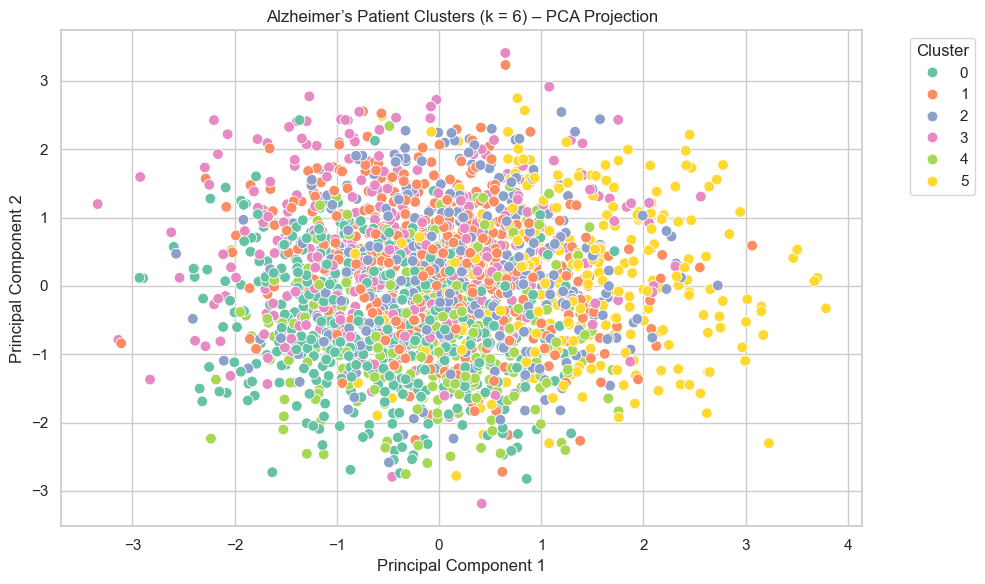

In [202]:
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

# Add PCA components and cluster label
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca['Cluster'] = df_scaled['Cluster']

# Plot PCA clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=60)
plt.title(f"Alzheimer’s Patient Clusters (k = {optimal_k}) – PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### What Do We See? 

The KMeans clustering suggests that the dataset can be grouped into distinct patient profiles based on their cognitive, functional, clinical, lifestyle, and demographic features. These subgroups may represent different stages of Alzheimer’s progression or different risk profiles, which can be explored in further research or modeling.

### Clusters with labels

In [206]:
# Select scaled features directly from df_scaled
X_cluster_scaled = df_scaled[cluster_features].values

# Fit KMeans
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
cluster_labels = final_kmeans.fit_predict(X_cluster_scaled)

# Assign to dataframe
df_scaled['Cluster'] = cluster_labels

In [208]:
# Descriptive labels for clinical interpretation (adjust as needed)
alz_cluster_labels = {
    0: "Healthy Aging",
    1: "Mild Cognitive Impairment",
    2: "Functional Decline",
    3: "Lifestyle Risk Group",
    4: "Advanced Cognitive Decline",
    5: "Mixed Cognitive & Vascular Risk"
}

# Map labels
df_scaled['ClusterLabel'] = df_scaled['Cluster'].map(alz_cluster_labels)

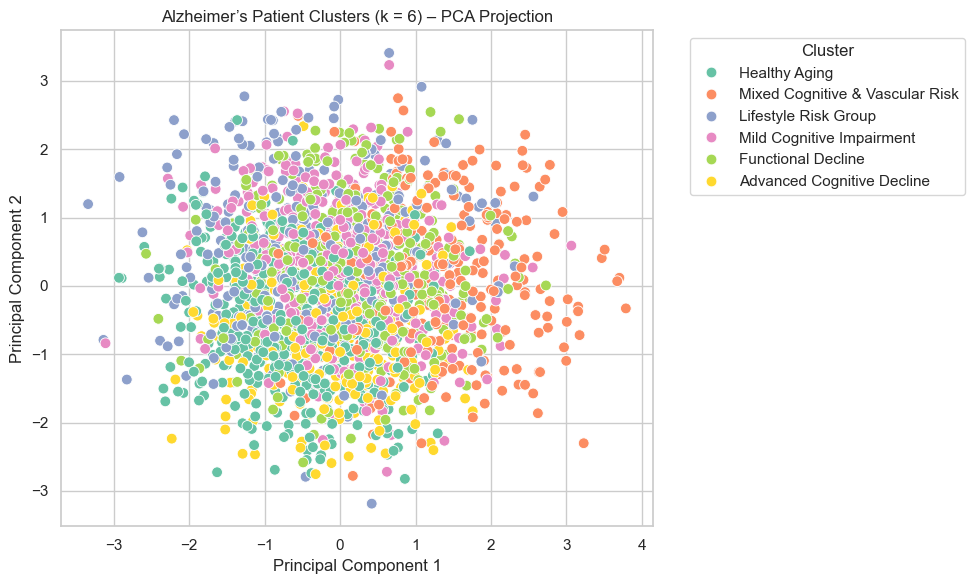

In [210]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

# Create PCA dataframe for plotting
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca['ClusterLabel'] = df_scaled['ClusterLabel']

# Plot PCA clusters with descriptive labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='ClusterLabel', palette='Set2', s=60)
plt.title(f"Alzheimer’s Patient Clusters (k = {optimal_k}) – PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Profile Clusters 

In [212]:
# Create cluster profiles (averaging features)
cluster_summary = df_scaled.groupby('Cluster')[cluster_features].mean().round(2)

# Apply descriptive labels to index
cluster_summary.index = cluster_summary.index.map(alz_cluster_labels)

# Export summary
cluster_summary.to_csv("../data/cluster_profiles.csv")
display(cluster_summary)

,MMSE,FunctionalAssessment,ADL,MemoryComplaints,BehavioralProblems,Confusion,Disorientation,Forgetfulness,PhysicalActivity,DietQuality,SleepQuality,AlcoholConsumption,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,SystolicBP,DiastolicBP,Age,Gender,FamilyHistoryAlzheimers
Cluster,,,,,,,,,,,,,,,,,,,,,
Healthy Aging,-0.08,0.02,-0.01,-0.51,-0.43,0.06,-0.43,0.06,0.03,0.04,-0.03,-0.00,0.01,-0.00,-0.05,0.04,-0.03,-0.01,-0.08,-1.01,-0.58
Mild Cognitive Impairment,0.02,0.03,0.03,-0.51,-0.43,-0.05,-0.43,-0.09,-0.02,-0.06,0.03,0.00,0.01,-0.01,0.01,0.01,0.01,0.02,0.02,0.99,-0.58
Functional Decline,0.04,0.01,-0.04,-0.07,-0.43,0.02,-0.43,0.08,-0.02,0.02,0.03,0.02,-0.02,-0.03,-0.04,0.00,0.03,0.01,-0.05,0.05,1.72
Lifestyle Risk Group,0.06,-0.05,0.10,-0.02,2.32,-0.05,-0.05,0.05,-0.03,-0.03,-0.05,0.03,-0.02,-0.01,0.06,0.02,-0.03,0.04,0.09,0.01,-0.05
Advanced Cognitive Decline,-0.11,-0.03,-0.10,1.95,-0.43,0.02,-0.43,-0.03,0.04,0.11,-0.01,-0.10,-0.03,0.02,0.05,-0.08,-0.06,-0.00,0.05,-0.01,-0.56
Mixed Cognitive & Vascular Risk,0.07,-0.00,-0.00,0.02,-0.43,0.01,2.31,-0.09,0.02,-0.05,0.03,0.03,0.03,0.05,0.01,-0.04,0.07,-0.08,0.00,0.05,0.13


#### What Do We See?  

The cluster profiles show that the algorithm successfully identified different patient subgroups based on their clinical, cognitive, lifestyle, and demographic characteristics. Some clusters (like "Healthy Aging" and "Mild Cognitive Impairment") represent patients with relatively normal or mild symptoms, while others (such as "Advanced Cognitive Decline" and "Mixed Cognitive & Vascular Risk") show more severe or complex patterns. The "Lifestyle Risk Group" also highlights behavioral factors that may play a role. These distinct groups could be useful for further clinical interpretation or targeted interventions.

### Add counts per cluster 

In [221]:
# Count number of samples per cluster
cluster_counts = df_scaled['Cluster'].value_counts().sort_index()

# Display
cluster_counts

Cluster
0    459
1    437
2    373
3    337
4    250
5    293
Name: count, dtype: int64

### Visualize Cluster Sizes

/var/folders/ct/0p5jxxp54xlcjs_q4dwkbdd80000gn/T/ipykernel_87261/1842237479.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='Set2')


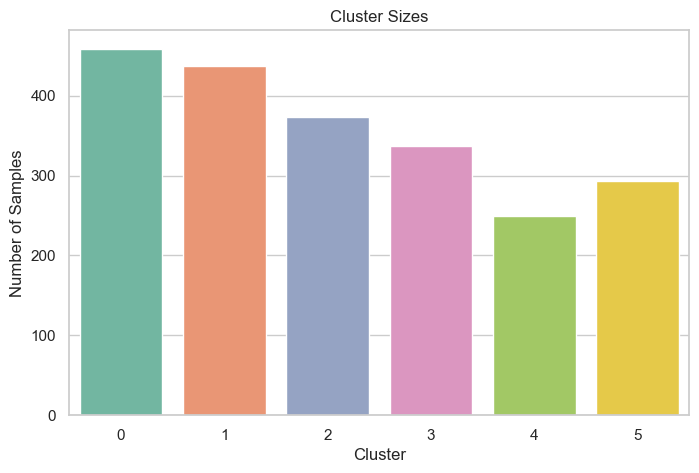

In [252]:
# Barplot of cluster sizes
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='Set2')
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Samples')
plt.show()

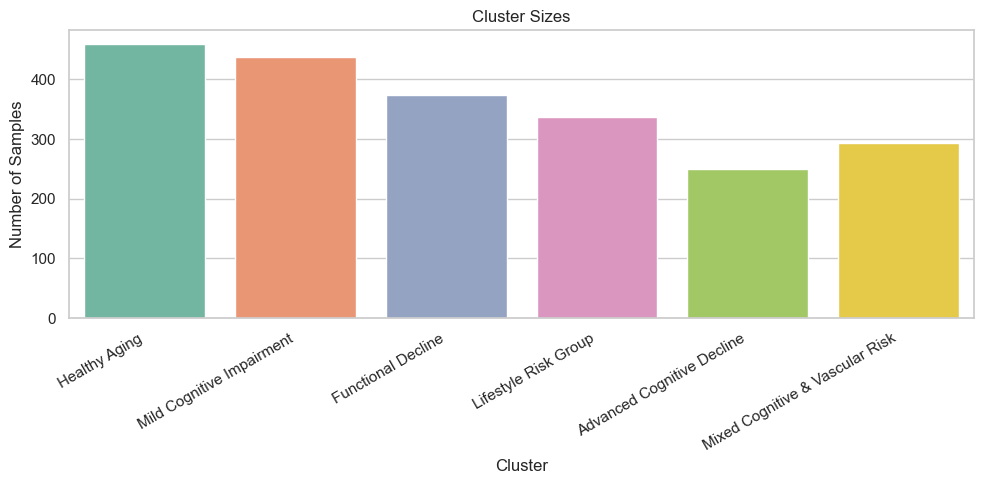

In [248]:
# Create dataframe for plotting
cluster_df = pd.DataFrame({
    'Cluster': cluster_names,
    'Count': cluster_counts.values
})

plt.figure(figsize=(10,5))
sns.barplot(data=cluster_df, x='Cluster', y='Count', palette='Set2', hue='Cluster', legend=False)
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Samples')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

### PCA + Cluster Interpretation

- Do certain clusters have higher MMSE scores?
- Are some clusters younger / older?
- Are certain lifestyle features different?

In [ ]:
#### What Do We See? 

-------------------

# KMeans with 2 clusters

In [169]:
from sklearn.cluster import KMeans

# Apply KMeans with 2 clusters (Alzheimer's vs Non-Alzheimer's)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_test)

# Add cluster assignments for comparison
df_clusters = pd.DataFrame({'True Diagnosis': y_test, 'Cluster': clusters})
print(df_clusters.head())

      True Diagnosis  Cluster
451                1        0
2080               1        1
1656               1        1
1070               1        1
830                1        1


### Visualizing Cluster Distribution

We compare the true diagnosis with cluster assignments using a confusion matrix to check how well KMeans clusters match actual diagnosis.

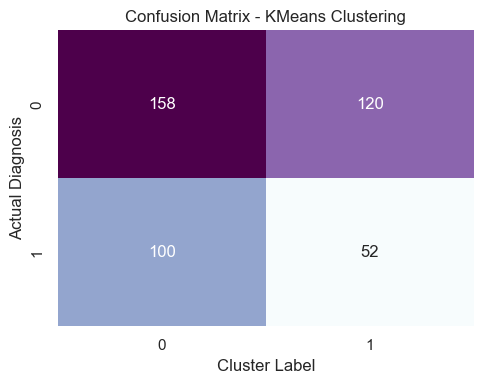

In [353]:
cm_kmeans = confusion_matrix(y_test, clusters)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_kmeans, annot=True, fmt="d", cmap="BuPu", cbar=False)
plt.xlabel("Cluster Label")
plt.ylabel("Actual Diagnosis")
plt.title("Confusion Matrix - KMeans Clustering")
plt.tight_layout()
plt.show()

#### Cluster Accuracy (adjusted for label flip)

Since KMeans assigns arbitrary cluster labels, we calculate clustering accuracy manually by checking both label assignments.

In [360]:
# Check both possible label mappings
accuracy_1 = accuracy_score(y_test, clusters)
accuracy_2 = accuracy_score(y_test, 1 - clusters)
kmeans_accuracy = max(accuracy_1, accuracy_2)

print("KMeans Clustering Accuracy (best mapping):", round(kmeans_accuracy, 4))

KMeans Clustering Accuracy (best mapping): 0.5116


### Visualizing Clusters with PCA

Since we have many features, we use Principal Component Analysis (PCA) to reduce the data into 2 dimensions for easy visualization of the clusters created by KMeans. This allows us to see if the clusters separate well in lower dimensions.

In [180]:
from sklearn.decomposition import PCA

# Apply PCA on test data (only features)
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Create a dataframe for plotting
pca_df = pd.DataFrame({
    'PC1': X_test_pca[:, 0],
    'PC2': X_test_pca[:, 1],
    'Cluster': clusters,
    'Diagnosis': y_test.reset_index(drop=True)
})

#### Plotting PCA Clusters (colored by KMeans clusters)

We first plot the clusters assigned by KMeans in 2D PCA space.

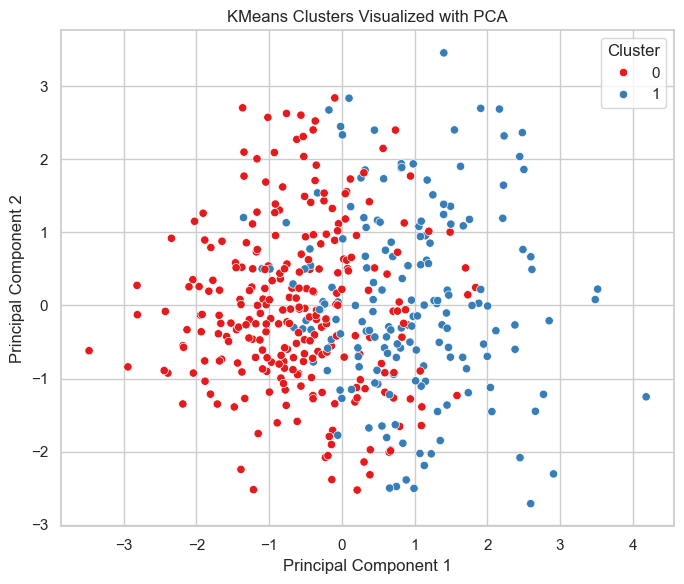

In [184]:
plt.figure(figsize=(7, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set1')
plt.title("KMeans Clusters Visualized with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

#### What Do We See? 

The PCA plot shows that the clusters found by KMeans overlap quite a bit, which means the data doesn’t naturally separate into clear groups on its own. This suggests that we might need to improve the features, try different clustering methods, or fine-tune the model to better separate the patient groups.

#### Plotting PCA Colored by True Diagnosis

We now plot the true Alzheimer's diagnosis labels in PCA space, to visually compare clustering vs true labels.

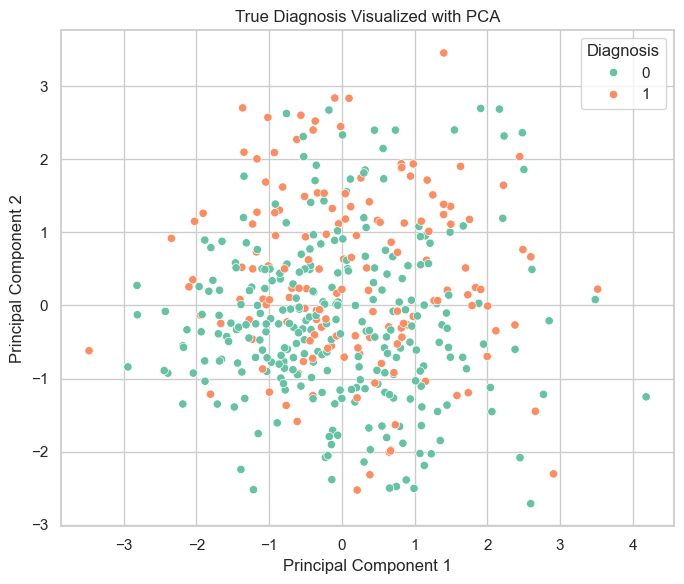

In [386]:
plt.figure(figsize=(7, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Diagnosis', palette='Set2')
plt.title("True Diagnosis Visualized with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Diagnosis')
plt.tight_layout()
plt.show()

#### What Do We See? 

The PCA plot, where points are colored by the true diagnosis, shows that Alzheimer’s and non-Alzheimer’s patients are quite mixed together. This means that the features we have don’t easily separate the two groups when we reduce the data to two dimensions. As a result, unsupervised methods like clustering may not work very well here. However, supervised learning methods, which use the actual diagnosis labels during training, can still perform well for this dataset.

-------------------------------

# Model Comparison Summary

We summarize the performance of all models by comparing Accuracy and ROC AUC scores side by side.
This helps us easily see which models performed better on this dataset.

In [396]:
# Build a summary dataframe
results = pd.DataFrame({
    'Model': [
        'Logistic Regression',
        'Random Forest',
        'Decision Tree',
        'Linear Regression (Illustration)',
        'KMeans Clustering (unsupervised)'
    ],
    'Accuracy': [
        accuracy,
        accuracy_rf,
        accuracy_dt,
        accuracy_lr,
        kmeans_accuracy
    ],
    'ROC AUC': [
        auc,
        auc_rf,
        auc_dt,
        auc_lr,
        'N/A'  # ROC AUC not applicable for unsupervised model
    ]
})

results

,Model,Accuracy,ROC AUC
0,Logistic Regression,0.823256,0.886998
1,Random Forest,0.941860,0.94092
2,Decision Tree,0.886047,0.883543
3,Linear Regression (Illustration),0.813953,0.883756
4,KMeans Clustering (unsupervised),0.511628,N/A


#### Precision Recall Curve

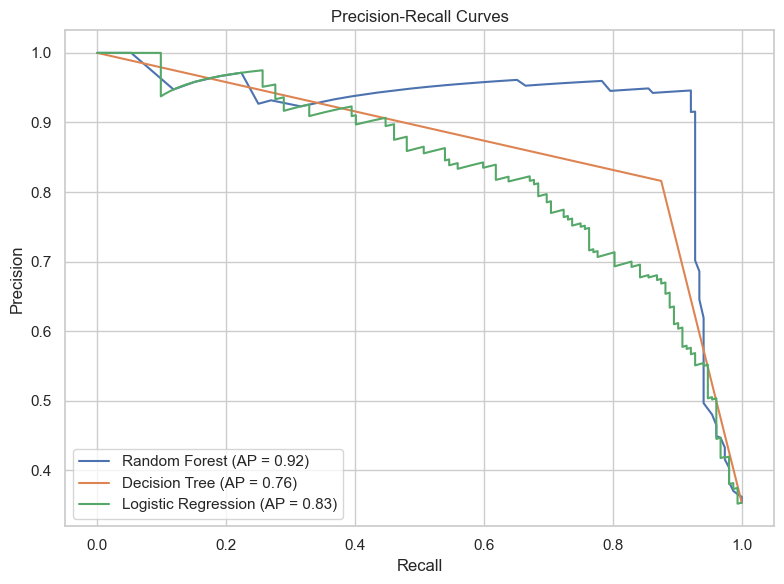

In [124]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Compute precision-recall and average precision for each model

# Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)
ap_rf = average_precision_score(y_test, y_prob_rf)

# Decision Tree
precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_prob_dt)
ap_dt = average_precision_score(y_test, y_prob_dt)

# Logistic Regression
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_prob)
ap_lr = average_precision_score(y_test, y_prob)

# Plot Precision-Recall Curves
plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, label="Random Forest (AP = {:.2f})".format(ap_rf))
plt.plot(recall_dt, precision_dt, label="Decision Tree (AP = {:.2f})".format(ap_dt))
plt.plot(recall_lr, precision_lr, label="Logistic Regression (AP = {:.2f})".format(ap_lr))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Summary Table for Average Precision

In [129]:
# Build the summary DataFrame
pr_results = pd.DataFrame({
    'Model': [
        'Random Forest',
        'Decision Tree',
        'Logistic Regression'
    ],
    'Average Precision': [
        ap_rf,
        ap_dt,
        ap_lr
    ]
})

# Display table
pr_results

,Model,Average Precision
0,Random Forest,0.916329
1,Decision Tree,0.758143
2,Logistic Regression,0.830665


## Random Forest: Feature Importances 

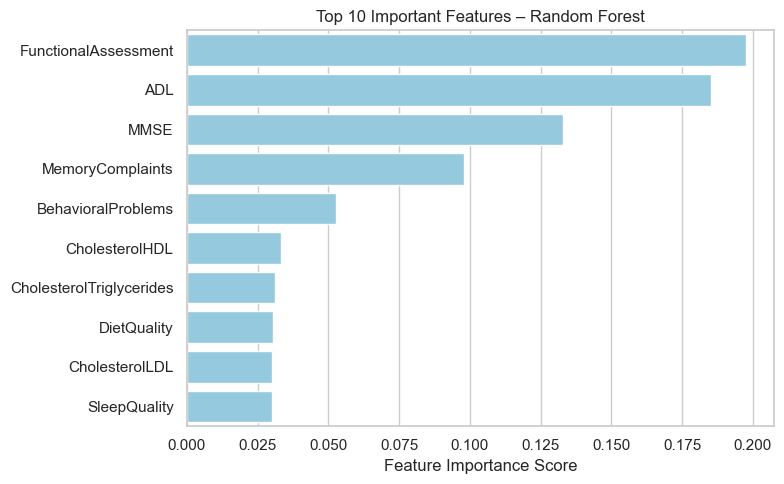

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Random Forest: feature importances
importances_rf = rf_model.feature_importances_

# Create DataFrame for importances
rf_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances_rf
}).sort_values(by='Importance', ascending=False)

# Plot top 10 important features
plt.figure(figsize=(8, 5))
sns.barplot(
    data=rf_importance_df.head(10),
    x='Importance',
    y='Feature',
    color='skyblue',
    errorbar=None
)
plt.title("Top 10 Important Features – Random Forest")
plt.xlabel("Feature Importance Score")
plt.ylabel("")
plt.tight_layout()
plt.show()

-----------------------

## Notebook Summary

In [136]:
import sys
sys.path.append("..")  # Move up one directory

from utils.save_tools import save_notebook_and_summary

save_notebook_and_summary(
    notebook_name="04_model_training_and_evaluation",
    summary={
        "description": "Trained and evaluated multiple supervised models for Alzheimer's classification using clinical, lifestyle, cognitive, and demographic features.",
        "records_analyzed": X.shape[0],
        "features_used": X.shape[1],
        "models_trained": [
            "Logistic Regression",
            "Decision Tree",
            "Random Forest"
        ],
        "evaluation_metrics": [
            "Accuracy",
            "Confusion Matrix",
            "ROC AUC Curve",
            "Precision-Recall Curve",
            "Average Precision"
        ],
        "key_results": {
            "best_model": "Random Forest",
            "best_accuracy": round(accuracy, 4),
            "best_auc": round(auc_rf, 4),
            "best_ap": round(ap_rf, 4)
        },
        "output_file": "../data/model_results.csv"
    }
)

Summary saved to: ../reports/04_model_training_and_evaluation_summary_2025-06-13_16-20-16.json


**This notebook concludes the model development and evaluation phase for Alzheimer’s risk prediction. We trained and compared multiple models using metrics such as accuracy, ROC AUC, confusion matrices, and precision-recall curves. Among the models tested, Random Forest demonstrated the strongest performance. In notebook (06_Results_and_Interpretation), we will focus on interpreting the model results, analyzing feature importance, and discussing the clinical relevance of the findings.**

-------------------------------